In [52]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  3 20:14:27 2018
@author: wmy
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [53]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=np.squeeze(train_Y), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

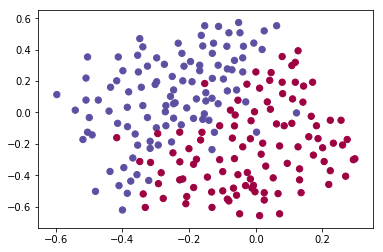

In [54]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()
plt.show()

In [55]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [56]:
class DeepNeuralNetwork():
    
    def __init__(self, name, layer_list):
        self.name = name
        self.Parameters_Init(layer_list)
        # it will be used when plot the costs picture
        self.iteration_unit = 1000
        print("You created a deep neural network named '" + self.name + "'")
        print('The layer list is ' + str(self.layer_list))
        pass
    
    def Parameters_Init(self, layer_list):
        self.layer_list = layer_list[:]
        np.random.seed(3)
        self.parameters = {}
        # number of layers in the network
        self.L = len(layer_list) - 1
        for l in range(1, self.L + 1):
            self.parameters['W' + str(l)] = np.random.randn(layer_list[l], \
                       layer_list[l-1]) * np.sqrt(1 / layer_list[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_list[l], 1))
            assert(self.parameters['W' + str(l)].shape == (layer_list[l], \
                                   layer_list[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_list[l], 1))
        return self.parameters
    
    def Sigmoid(self, x):
        s = 1 / (1 + np.exp(-x))
        return s

    def ReLU(self, x):
        s = np.maximum(0, x)
        return s
    
    def Forward_Propagation(self, X):
        # copy the dataset X (or A0)
        self.dataset = {} 
        self.dataset['X'] = X[:]
        # the number of datasets
        self.m = X.shape[1]
        # the caches for hidden and output layers
        self.caches = []
        assert(self.L == len(self.parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            # cache : (Zl, Al, Wl, bl)
            cache = (Z, A_now, W, b)
            self.caches.append(cache)
        WL = self.parameters['W' + str(self.L)]
        bL = self.parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        self.AL = self.Sigmoid(ZL)
        cache = (ZL, self.AL, WL, bL)
        self.caches.append(cache)
        # check the shape
        assert(self.AL.shape == (1, X.shape[1]))
        return self.AL, self.caches
    
    def Compute_Cost(self, Y):
        assert(self.m == Y.shape[1])
        # - (y * log(a) + (1-y) * log(1-a))
        logprobs = np.multiply(-np.log(self.AL),Y) + \
        np.multiply(-np.log(1 - self.AL), 1 - Y)
        # the average of the loss function
        cost = 1.0/self.m * np.nansum(logprobs)
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        self.cost = cost
        return self.cost
    
    def Backward_Propagation(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            dZ = np.multiply(dA, np.int64(A_current > 0))
            dW = 1.0/m * np.dot(dZ, A_before.T)
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Update_Parameters(self, learning_rate):
        assert(self.L == len(self.parameters) // 2)
        L = self.L
        for l in range(L):
            # W = W - a * dW
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - \
            learning_rate * self.grads["dW" + str(l + 1)]
            # b = b - a * db
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - \
            learning_rate * self.grads["db" + str(l + 1)]    
        return self.parameters
    
    def Train(self, X, Y, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations+1):
            self.Forward_Propagation(X)
            cost = self.Compute_Cost(Y)
            self.Backward_Propagation(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def Query(self, X, Y):
        m = X.shape[1]
        p = np.zeros((1,m))
        probs, caches = self.Forward_Propagation(X)
        for i in range(0, probs.shape[1]):
            if probs[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        print("Accuracy: "  + str(100*np.sum((p == Y)/m)) + '%')    
        return p
    
    def Predict(self, X):
        m = X.shape[1]
        p = np.zeros((1,m))
        probs, caches = self.Forward_Propagation(X)
        for i in range(0, probs.shape[1]):
            if probs[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        return p   
    
    def PlotCosts(self):
        plt.plot(np.squeeze(self.costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per ' + str(self.iteration_unit) + ')')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
    
    def Dropout_Init(self, keep_prob_list):
        self.keep_prob_list = keep_prob_list
        pass
    
    def Forward_Propagation_Dropout(self, X):
        # choose the random seed
        np.random.seed(1)
        # copy the dataset X (or A0)
        self.dataset = {} 
        self.dataset['X'] = X[:]
        self.m = X.shape[1]
        # the caches for hidden and output layers
        self.caches = []
        self.D = {}
        assert(self.L == len(self.parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            # dropout
            self.D['D' + str(l)] = np.random.rand(A_now.shape[0], \
                   A_now.shape[1]) 
            self.D['D' + str(l)] = (self.D['D' + str(l)] < \
                  self.keep_prob_list[l - 1])
            A_now = A_now * self.D['D' + str(l)]
            A_now = A_now / self.keep_prob_list[l - 1]
            # cache : (Zl, Al, Wl, bl)
            cache = (Z, A_now, W, b)
            self.caches.append(cache)
        WL = self.parameters['W' + str(self.L)]
        bL = self.parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        self.AL = self.Sigmoid(ZL)
        cache = (ZL, self.AL, WL, bL)
        self.caches.append(cache)
        # check the shape
        assert(self.AL.shape == (1, X.shape[1]))
        return self.AL, self.caches
    
    def Backward_Propagation_Dropout(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            # dropout
            dA = dA * self.D['D' + str(l + 1)]
            dA = dA / self.keep_prob_list[l]
            # dropout finished
            dZ = np.multiply(dA, np.int64(A_current > 0))
            dW = 1.0/m * np.dot(dZ, A_before.T)
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Train_Dropout(self, X, Y, keep_prob_list, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.Dropout_Init(keep_prob_list)
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations+1):
            self.Forward_Propagation_Dropout(X)
            cost = self.Compute_Cost(Y)
            self.Backward_Propagation_Dropout(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def L2_Regularization_Init(self, lambda_list):
        self.lambda_list = lambda_list[:]
        pass
    
    def Compute_Cost_L2_Regularization(self, Y):
        m = Y.shape[1]
        cross_entropy_cost = self.Compute_Cost(Y)
        L2_regularization_cost = 0.0
        for l in range(1, self.L + 1):
            Wl = self.parameters['W' + str(l)]
            L2_regularization_cost +=  1.0/m * \
            self.lambda_list[l - 1]/2 * np.sum(np.square(Wl))
        cost = cross_entropy_cost + L2_regularization_cost
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        self.cost = cost
        return self.cost
    
    def Backward_Propagation_L2_Regularization(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        # L2 regularization
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['dW' + str(L)] += self.lambda_list[-1] / m * WL
        # L2 regularization finished
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            dZ = np.multiply(dA, np.int64(A_current > 0))
            # L2 regularization
            dW = 1.0/m * np.dot(dZ, A_before.T)
            dW += self.lambda_list[l] / m * W_current
            # L2 regularization finished
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Train_L2_Regularization(self, X, Y, lambda_list, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.L2_Regularization_Init(lambda_list)
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost_L2_Regularization(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations + 1):
            self.Forward_Propagation(X)
            cost = self.Compute_Cost_L2_Regularization(Y)
            self.Backward_Propagation_L2_Regularization(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def J(self, X, Y, parameters):
        # the number of datasets
        m = X.shape[1]
        assert(self.L == len(parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            pass
        WL = parameters['W' + str(self.L)]
        bL = parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        AL = self.Sigmoid(ZL)
        # check the shape
        assert(AL.shape == (1, X.shape[1]))
        # Cost
        logprobs = np.multiply(-np.log(AL),Y) + \
        np.multiply(-np.log(1 - AL), 1 - Y)
        cost = 1.0/m * np.sum(logprobs)
        return cost
    
    def Dictionary_To_Vector(self, parameters):
        keys = []
        count = 0
        for l in range(1, self.L + 1):
            for key in ['W' + str(l), 'b' + str(l)]:
                new_vector = np.reshape(parameters[key], (-1,1))
                keys = keys + [key]*new_vector.shape[0]
                if count == 0:
                    theta = new_vector
                else:
                    theta = np.concatenate((theta, new_vector), axis=0)
                count = count + 1
        return theta, keys
    
    def Vector_To_Dictionary(self, theta):
        parameters = {}
        star = 0
        for l in range(1, self.L + 1):
            parameters['W' + str(l)] = \
            theta[star:star + self.parameters['W' + str(l)].shape[0] * \
                                              self.parameters['W' + str(l)].shape[1]].reshape(self.parameters['W' + str(l)].shape)
            star = star + self.parameters['W' + str(l)].shape[0] * \
            self.parameters['W' + str(l)].shape[1]
            parameters['b' + str(l)] = \
            theta[star:star + self.parameters['b' + str(l)].shape[0] * \
                                              self.parameters['b' + str(l)].shape[1]].reshape(self.parameters['b' + str(l)].shape)
            star = star + self.parameters['b' + str(l)].shape[0] * \
            self.parameters['b' + str(l)].shape[1]
        return parameters
   
    def Gradients_To_Vector(self, gradients):
        count = 0
        for l in range(1, self.L + 1):
            for key in ['dW' + str(l), 'db' + str(l)]:
                new_vector = np.reshape(gradients[key], (-1,1))
                if count == 0:
                    theta = new_vector
                else:
                    theta = np.concatenate((theta, new_vector), axis=0)
                count = count + 1
                pass
            pass
        return theta
    
    def Gradient_Check(self, parameters, gradients, X, Y, epsilon = 1e-7):
        # Set-up variables
        parameters_values, _ = self.Dictionary_To_Vector(parameters)
        grad = self.Gradients_To_Vector(gradients)
        num_parameters = parameters_values.shape[0]
        J_plus = np.zeros((num_parameters, 1))
        J_minus = np.zeros((num_parameters, 1))
        gradapprox = np.zeros((num_parameters, 1))
        # Compute gradapprox
        for i in range(num_parameters):
            # J plus
            thetaplus = np.copy(parameters_values)              
            thetaplus[i][0] += epsilon                           
            J_plus[i]= self.J(X, Y, self.Vector_To_Dictionary(thetaplus)) 
            # J minus
            thetaminus = np.copy(parameters_values)                                  
            thetaminus[i][0] -= epsilon                            
            J_minus[i] = self.J(X, Y, self.Vector_To_Dictionary(thetaminus))
            # Compute gradapprox[i]
            gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
            pass
        numerator = np.linalg.norm(grad - gradapprox)                      
        denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)               
        difference = numerator / denominator   
        if difference > 1e-7:
            print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
        return difference  

    def Check_The_Gradient(self, X, Y, epsilon = 1e-7):
        print('Gradient checking...please wait.')
        self.Forward_Propagation(X)
        self.Backward_Propagation(Y)
        parameters = self.parameters
        gradients = self.grads
        difference = self.Gradient_Check(parameters, gradients, X, Y, epsilon = epsilon)
        return difference
    
    pass

In [57]:
n = DeepNeuralNetwork('Model without regularization', [train_X.shape[0], 20, 3, 1])

You created a deep neural network named 'Model without regularization'
The layer list is [2, 20, 3, 1]


Cost after iteration 0: 0.655741
Accuracy: 62.55924170616114%
Cost after iteration 10000: 0.167290
Accuracy: 92.41706161137442%
Cost after iteration 20000: 0.139257
Accuracy: 92.89099526066352%
Cost after iteration 30000: 0.125091
Accuracy: 94.7867298578199%
finished!


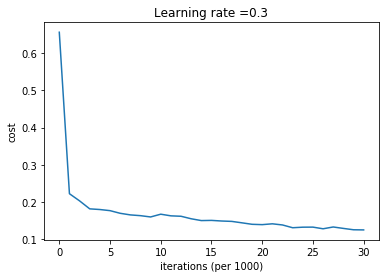

[0.6557412523481002,
 0.22229186722865296,
 0.2030429673128164,
 0.18162055473930508,
 0.1798418508279171,
 0.17681454772277347,
 0.16971888571056912,
 0.1654064182487829,
 0.16335638504126446,
 0.159878930606798,
 0.1672896780745752,
 0.16287856112090915,
 0.161727039410266,
 0.15500774865502306,
 0.15015623888302512,
 0.15065813435396166,
 0.14899611684281008,
 0.14797598878061763,
 0.14412563057014177,
 0.14017622732057458,
 0.13925724756538535,
 0.1414821210252786,
 0.13839476817601018,
 0.13095809110398876,
 0.13241293302834165,
 0.13259061714223164,
 0.12814587314138,
 0.13296970215816792,
 0.1291471879544345,
 0.12549896717780193,
 0.1250913124510784]

In [58]:
n.Train(train_X, train_Y, learning_rate = 0.3, iterations = 30000, print_cost = True)

In [59]:
n.Check_The_Gradient(train_X, train_Y)

Gradient checking...please wait.
Your backward propagation works perfectly fine! difference = 1.1109706770550774e-09


1.1109706770550774e-09

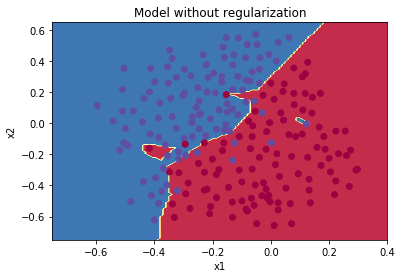

In [60]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: n.Predict(x.T), train_X, np.squeeze(train_Y))     

In [61]:
n.Query(test_X, test_Y)

Accuracy: 91.49999999999999%


array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0.]])

In [62]:
b = DeepNeuralNetwork('Model with L2-regularization', [train_X.shape[0], 20, 3, 1])

You created a deep neural network named 'Model with L2-regularization'
The layer list is [2, 20, 3, 1]


Cost after iteration 0: 0.697448
Accuracy: 62.55924170616114%
Cost after iteration 10000: 0.268528
Accuracy: 93.36492890995261%
Cost after iteration 20000: 0.268115
Accuracy: 93.36492890995261%
Cost after iteration 30000: 0.267862
Accuracy: 93.8388625592417%
finished!


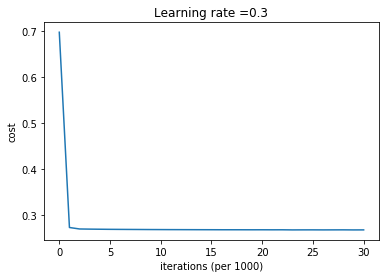

[0.6974484493131264,
 0.27305201560084535,
 0.2698466369409882,
 0.2695217523300151,
 0.26928957853475893,
 0.2690784143730685,
 0.2689367634438058,
 0.26882189277268426,
 0.268722732103161,
 0.2686020654856892,
 0.2685275133539669,
 0.26843509076698446,
 0.2683867489167247,
 0.2683260953962501,
 0.26826924041185957,
 0.26822522524509845,
 0.26816800586048245,
 0.2681471919232646,
 0.26813666101037825,
 0.2680893135806962,
 0.2681151781050506,
 0.26804866554852985,
 0.26808130679547804,
 0.2678375423200623,
 0.2679209322321695,
 0.2679452685458971,
 0.26785568454562947,
 0.26791296058597974,
 0.2679658652398398,
 0.26780525990806087,
 0.26786174287095865]

In [63]:
b.Train_L2_Regularization(train_X, train_Y, [0.7, 0.7, 0.7], learning_rate = 0.3, iterations = 30000, print_cost = True)

In [64]:
b.Check_The_Gradient(train_X, train_Y)

Gradient checking...please wait.
Your backward propagation works perfectly fine! difference = 8.092373520478463e-09


8.092373520478463e-09

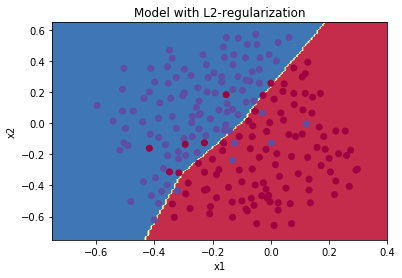

In [65]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: b.Predict(x.T), train_X, np.squeeze(train_Y))     

In [66]:
b.Query(test_X, test_Y)

Accuracy: 92.99999999999999%


array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0.]])

In [67]:
a = DeepNeuralNetwork('Model with dropout', [train_X.shape[0], 20, 3, 1])

You created a deep neural network named 'Model with dropout'
The layer list is [2, 20, 3, 1]


Cost after iteration 0: 0.655741
Accuracy: 62.55924170616114%


C:\Users\wmy\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log
C:\Users\wmy\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 10000: 0.061041
Accuracy: 92.41706161137442%
Cost after iteration 20000: 0.060587
Accuracy: 92.41706161137442%
Cost after iteration 30000: 0.060488
Accuracy: 92.89099526066352%
finished!


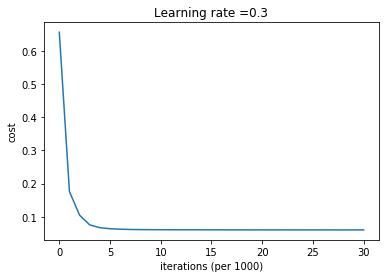

[0.6557412523481002,
 0.17600847725170224,
 0.10483183614871773,
 0.07561075635805893,
 0.06720290401196519,
 0.06409841680453639,
 0.06257665205475928,
 0.06175432149482573,
 0.06142473891118082,
 0.0612238777387273,
 0.06104078803484406,
 0.06095157541262749,
 0.060838702294367,
 0.06088567499284105,
 0.06085460603727516,
 0.06067098025782248,
 0.060655164952484165,
 0.06063176755308175,
 0.06066649159074859,
 0.06056479374062982,
 0.06058685639733366,
 0.06056512465949691,
 0.06058350420471249,
 0.06057453372564164,
 0.06050685195658941,
 0.06050386293410501,
 0.06052490163217655,
 0.060474678441555345,
 0.060473457444417095,
 0.060488523733386014,
 0.06048817515244604]

In [68]:
a.Train_Dropout(train_X, train_Y, [0.86, 0.86], learning_rate = 0.3, iterations = 30000, print_cost = True)

In [69]:
a.Check_The_Gradient(train_X, train_Y)

Gradient checking...please wait.
Your backward propagation works perfectly fine! difference = nan


C:\Users\wmy\Anaconda3\lib\site-packages\ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in log
C:\Users\wmy\Anaconda3\lib\site-packages\ipykernel_launcher.py:387: RuntimeWarning: invalid value encountered in multiply


nan

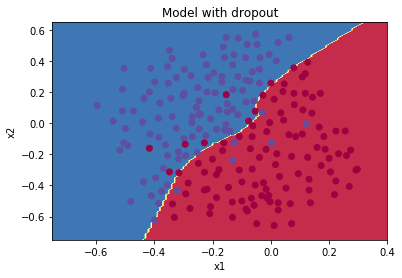

In [70]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: a.Predict(x.T), train_X, np.squeeze(train_Y))     

In [71]:
a.Query(test_X, test_Y)

Accuracy: 94.99999999999999%


array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0.]])